# NEU defect classification problem

In the Northeastern University (NEU) surface defect database, six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). An example of the six kinds of typical surface defects can be seen in the following images.

The database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects. The origeinal resolution of each image is 200x200 pixels. 900 images will be used for train images and the rest 600 images will be used for test images. The NEU surface defect database includes two difficult challenges: 1.The intra-class defects existing large differences in appearance while the inter-class defects have similar aspects; 2. The defect images suffer from the influence of illumination and material changes. 

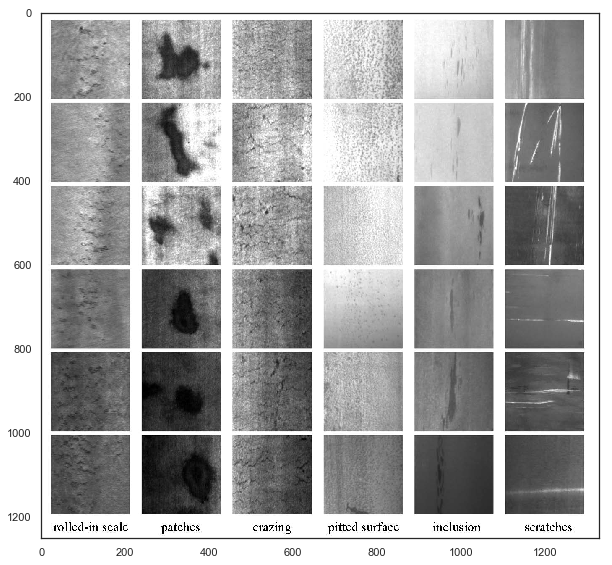

In [2]:
content_image = imageio.imread("D:\Python\CV project - defect classification\legend.jpg")
plt.figure(figsize = (10,10)) 
imshow(content_image)

In [94]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import pandas as pd
import imageio
from skimage import io
import scipy.misc
from skimage.color import gray2rgb
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
import seaborn as sns
sns.set(style='white')
import keras.backend as K
from keras.models import Model
from keras.applications import vgg16, vgg19, inception_v3, resnet50
from keras.utils import np_utils
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras import optimizers

neu_root = 'D:\Python\CV project - defect classification'

CNNs typically require a large image dataset to train. In this project, we will implement transfer learning for this defect database classification problem, i.e. we will build our model on the top of pre-trained image classification models. The pre-trained models will be used as feature extractors. The performace of four pre-trained CNN architectures will be investigated:
1. VGG16
2. VGG19
3. InceptionV3
4. ResNet50

For all of the four models, only the final fully reconnected layers will be re-trained. It turns out that the highest accuracy is achieved when using VGG16 and VGG19, the test accuracy is about 99%.

In [3]:
# load train and test file names
def load_labels(filepath):
    with open(filepath, 'r') as f:
        return [line.strip() for line in f]


train_files = load_labels(os.path.join(neu_root, 'train.txt'))
test_files = load_labels(os.path.join(neu_root, 'test.txt'))

In [4]:
# load images and labels
def load_images(image_files):
    """ load images into numpy array """

    images = [io.imread(os.path.join(neu_root, 'data', p)) for p in image_files]
    images = np.array(images)

    get_image_class = lambda path: path.split('_')[0]
    labels = list(map(get_image_class, image_files))
    return np.array(images), labels

train_images, train_labels = load_images(train_files)
test_images, test_labels = load_images(test_files)


label_dict = {label: idx
              for idx, label in enumerate(sorted(set(train_labels)))}

y_train = np.array([label_dict[label] for label in train_labels])
y_test = np.array([label_dict[label] for label in test_labels])

# 1.VGG16

VGG16 is a widely used CNN with 16 weighted layers proposed by the Visual Geometry Group in the University of Oxford in 2014. The structure of vgg16 is as below. In this architecture, there are five stacks of convolutional layers, each consisting of two or three convolutional layers followed by a max pooling layer. Finally, there are three fully reconnected layers connected to the softmax output layer for the final prediction (1000 categories). For this project, we will extract the fc2 layer from this model (all of the parameters in this layer and prior to this layer remain unchanged), and build our fully connected layer on the top of it for the final prediction for this dataset (6 categories).

In [5]:
model = vgg16.VGG16(weights=None)
print("model structure: ", model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
def preprocess_images_vgg16(images):
    """ expect a 3D array containing grayscale uint8 images """
    
    # resize images with scipy
    I = np.array([resize(image, (224,224)) for image in images])
    
    # convert to RGB and apply imagenet preprocessing
    I = gray2rgb(I).astype(np.float32)

    return vgg16.preprocess_input(I)

In [7]:
def vgg16_layer(output_name='fc1'):
    # Note: currently hippolyta compute nodes cannot access user home directories,
    # and do not have direct internet access.
    # use full paths to NFS filesystem endpoints (not symlinks)
    # keras pretrained model weight files are here:
    KERAS_ROOT = 'D:\Python\CV Project - defect classification'
    weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    weights_path = os.path.join(KERAS_ROOT, 'models', weights_file)

    # initialize network with random weights, and load from hdf5
    cnn = vgg16.VGG16(include_top=True, weights=None)
    cnn.load_weights(filepath=weights_path)

    model = Model(inputs=cnn.input,outputs=cnn.get_layer(output_name).output)
    return model

In [8]:
def cached_forward_pass_vgg16(images, phase='train', layername='fc2', datadir='../data'):
        
    datafile = os.path.join(datadir, 'neu-vgg16-{}-{}.npy'.format(layername, phase))
    try:
        features = np.load(datafile)
    except FileNotFoundError:
        print('forward pass for NEU {}ing images'.format(phase))
        model = vgg16_layer(layername)
        features = model.predict(preprocess_images_vgg16(images), verbose=False)
        np.save(datafile, features)

    return features

In [9]:
datadir='D:\Python\CV Project - defect classification\data'

fc2_train = cached_forward_pass_vgg16(train_images, phase='train', layername='fc2', datadir=datadir)
fc2_test = cached_forward_pass_vgg16(test_images, phase='test', layername='fc2', datadir=datadir)

In [10]:
def linear_softmax_classifier(n_classes=6, input_dim=2048):
    
    input_layer = Input(shape=(input_dim,))
    output_layer = Dense(n_classes, input_shape=(input_dim,), activation='softmax')(input_layer)

    return Model(inputs=input_layer, outputs=output_layer)

In [21]:
lsc_vgg16 = linear_softmax_classifier(input_dim=4096)
opt = optimizers.Adam(lr=0.001)
lsc_vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(y_train)

# shuffle training data to get shuffled validation data
ntrain = train_images.shape[0]
initial_shuf = np.random.permutation(ntrain)
X = fc2_train[initial_shuf]
y = target[initial_shuf]

hist = lsc_vgg16.fit(X, y, validation_split=0.2, epochs=20)

Train on 960 samples, validate on 240 samples
Epoch 1/20
960/960 [==============================] - 9s 9ms/step - loss: 0.5602 - acc: 0.8281 - val_loss: 0.0718 - val_acc: 0.9833
Epoch 2/20
960/960 [==============================] - 0s 143us/step - loss: 0.0523 - acc: 0.9896 - val_loss: 0.0373 - val_acc: 0.9958
Epoch 3/20
960/960 [==============================] - 0s 150us/step - loss: 0.0273 - acc: 0.9979 - val_loss: 0.0248 - val_acc: 0.9958
Epoch 4/20
960/960 [==============================] - 0s 179us/step - loss: 0.0189 - acc: 0.9990 - val_loss: 0.0176 - val_acc: 1.0000
Epoch 5/20
960/960 [==============================] - 0s 179us/step - loss: 0.0145 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 1.0000
Epoch 6/20
960/960 [==============================] - 0s 229us/step - loss: 0.0112 - acc: 1.0000 - val_loss: 0.0115 - val_acc: 1.0000
Epoch 7/20
960/960 [==============================] - 0s 117us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 8/20
960/960

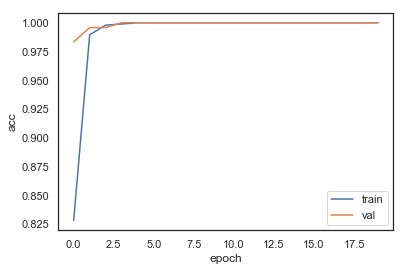

In [22]:
metric = 'acc' # 'loss' | 'acc'
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch')
plt.ylabel(metric)
plt.legend()

In [32]:
# apply the model to test data
p = lsc_vgg16.predict(fc2_test)
p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
pred = np.argmax(p, axis=-1)
acc_vgg16 = round(accuracy_score(pred, y_test) * 100, 2)
print('The accuracy for vgg16 model is ' + str(acc_vgg16) + '%')

The accuracy for vgg16 model is 99.67%


In [ ]:
#p = lsc_fc2.predict(fc2_test)
#p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
#pred = np.argmax(p, axis=-1)
#f1_vgg16 = round(f1_score(pred, y_test,average='micro') * 100, 2)
#print(acc_vgg16)

In [14]:
def evaluate_confusion_matrix(model, testdata, y_test):

    p = model.predict(testdata)
    p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
    pred = np.argmax(p, axis=-1)

    conf = confusion_matrix(y_test, pred)
    sns.heatmap(
        conf, annot=True, square=True, 
        mask=(conf == 0), linewidths=.5, linecolor='k',
        xticklabels=sorted(set(train_labels)),
        yticklabels=sorted(set(train_labels))
    )

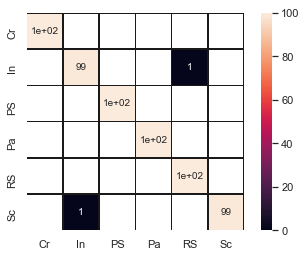

In [25]:
evaluate_confusion_matrix(lsc_vgg16, fc2_test, y_test)

# 2. VGG19

VGG19 refers to a VGG model with 19 weighted layers. The structure of VGG19 is as below.

In [16]:
model = vgg19.VGG19(weights=None)
print("model structure: ", model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
def preprocess_images_vgg19(images):
    """ expect a 3D array containing grayscale uint8 images """
    
    # resize images with scipy
    I = np.array([resize(image, (224,224)) for image in images])
    
    # convert to RGB and apply imagenet preprocessing
    I = gray2rgb(I).astype(np.float32)

    return vgg19.preprocess_input(I)

In [18]:
def vgg19_layer(output_name='fc1'):
    # Note: currently hippolyta compute nodes cannot access user home directories,
    # and do not have direct internet access.
    # use full paths to NFS filesystem endpoints (not symlinks)
    # keras pretrained model weight files are here:
    # KERAS_ROOT = 'D:\Python\CV Project\defect'
    # weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    # weights_path = os.path.join(KERAS_ROOT, 'models', weights_file)

    # initialize network with random weights, and load from hdf5
    cnn = vgg19.VGG19(include_top=True, weights='imagenet')
    #cnn.load_weights(filepath=weights_path)

    model = Model(inputs=cnn.input,outputs=cnn.get_layer(output_name).output)
    return model

In [19]:
def cached_forward_pass_vgg19(images, phase='train', layername='fc2', datadir='../data'):
        
    datafile = os.path.join(datadir, 'neu-vgg19-{}-{}.npy'.format(layername, phase))
    try:
        features = np.load(datafile)
    except FileNotFoundError:
        print('forward pass for NEU {}ing images'.format(phase))
        model = vgg19_layer(layername)
        features = model.predict(preprocess_images_vgg16(images), verbose=False)
        np.save(datafile, features)

    return features

In [27]:
datadir='D:\Python\CV Project - defect classification\data'

v19fc2_train = cached_forward_pass_vgg19(train_images, phase='train', layername='fc2', datadir=datadir)
v19fc2_test = cached_forward_pass_vgg19(test_images, phase='test', layername='fc2', datadir=datadir)

In [28]:
lsc_vgg19 = linear_softmax_classifier(input_dim=4096)
opt = optimizers.Adam(lr=0.001)
lsc_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(y_train)

# shuffle training data to get shuffled validation data
ntrain = train_images.shape[0]
initial_shuf = np.random.permutation(ntrain)
X = v19fc2_train[initial_shuf]
y = target[initial_shuf]

hist = lsc_vgg19.fit(X, y, validation_split=0.2, epochs=20)

Train on 960 samples, validate on 240 samples
Epoch 1/20
960/960 [==============================] - 5s 5ms/step - loss: 0.4003 - acc: 0.8781 - val_loss: 0.0616 - val_acc: 0.9833
Epoch 2/20
960/960 [==============================] - 0s 87us/step - loss: 0.0547 - acc: 0.9885 - val_loss: 0.0357 - val_acc: 0.9958
Epoch 3/20
960/960 [==============================] - 0s 87us/step - loss: 0.0314 - acc: 0.9948 - val_loss: 0.0226 - val_acc: 0.9958
Epoch 4/20
960/960 [==============================] - 0s 83us/step - loss: 0.0224 - acc: 0.9958 - val_loss: 0.0220 - val_acc: 0.9958
Epoch 5/20
960/960 [==============================] - 0s 79us/step - loss: 0.0158 - acc: 0.9990 - val_loss: 0.0168 - val_acc: 0.9958
Epoch 6/20
960/960 [==============================] - 0s 79us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0153 - val_acc: 0.9958
Epoch 7/20
960/960 [==============================] - 0s 83us/step - loss: 0.0114 - acc: 0.9990 - val_loss: 0.0185 - val_acc: 0.9958
Epoch 8/20
960/960 [====

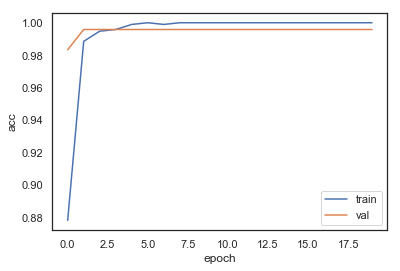

In [29]:
metric = 'acc' # 'loss' | 'acc'
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch')
plt.ylabel(metric)
plt.legend()

In [33]:
# apply the model to test data
p = lsc_vgg19.predict(v19fc2_test)
p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
pred = np.argmax(p, axis=-1)
acc_vgg19 = round(accuracy_score(pred, y_test) * 100, 2)
print('The accuracy for vgg19 model is ' + str(acc_vgg19) + '%')

The accuracy for vgg19 model is 99.83%


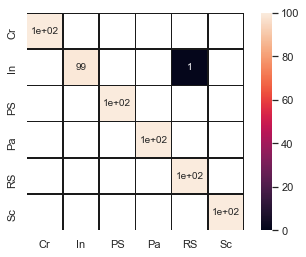

In [34]:
evaluate_confusion_matrix(lsc_vgg19, v19fc2_test, y_test)

# 3. InceptionV3

The Inception model was introduced by researchers at Google for  the 2014 ImageNet competition. The model is comprised of a basic unit referred to as an "Inception cell" in which we perform a series of convolutions at different scales and subsequently aggregate the results. The structure of InceptionV3 is as below. The network is 48 layers deep and can classify images into 1000 categories. The number of parameters and computational cost of Inception is much lower than VGG net.

In [35]:
model = inception_v3.InceptionV3(weights=None)
print("model structure: ", model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [36]:
def preprocess_images_inception(images):
    """ expect a 3D array containing grayscale uint8 images """

    # resize images with scipy
    I = np.array([resize(image, (224,224)) for image in images])

    # convert to RGB and apply imagenet preprocessing
    I = gray2rgb(I).astype(np.float32)

    return inception_v3.preprocess_input(I)

In [37]:
def inception_layer(output_name='avg_pool'):
    # Note: currently hippolyta compute nodes cannot access user home directories,
    # and do not have direct internet access.
    # use full paths to NFS filesystem endpoints (not symlinks)
    # keras pretrained model weight files are here:
    #KERAS_ROOT = 'D:\Python\CV Project\defect'
    #weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    #weights_path = os.path.join(KERAS_ROOT, 'models', weights_file)

    # initialize network with random weights, and load from hdf5
    cnn = inception_v3.InceptionV3(include_top=True, weights='imagenet', classes=1000)
    #cnn.load_weights(filepath=weights_path)

    model = Model(
        inputs=cnn.input,
        outputs=cnn.get_layer(output_name).output
    )

    return model

In [38]:
def cached_forward_pass_inception(images, phase='train', layername='avg_pool', datadir='../data'):
        
    datafile = os.path.join(datadir, 'neu-inception-{}-{}.npy'.format(layername, phase))
    try:
        features = np.load(datafile)
    except FileNotFoundError:
        print('forward pass for NEU {}ing images'.format(phase))
        model = inception_layer(layername)
        features = model.predict(preprocess_images_inception(images), verbose=True)
        np.save(datafile, features)

    return features

In [40]:
datadir='D:\Python\CV Project - defect classification\data'

ap_train = cached_forward_pass_inception(train_images, phase='train', layername='avg_pool', datadir=datadir)
ap_test = cached_forward_pass_inception(test_images, phase='test', layername='avg_pool', datadir=datadir)

In [77]:
ntrain = train_images.shape[0]

lsc_inception = linear_softmax_classifier(input_dim=2048)
opt = optimizers.Adam(lr=0.003)
lsc_inception.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(y_train)

# shuffle training data to get shuffled validation data
initial_shuf = np.random.permutation(ntrain)
X = ap_train[initial_shuf]
y = target[initial_shuf]

hist = lsc_inception.fit(X, y, validation_split=0.2, epochs=200)

Train on 960 samples, validate on 240 samples
Epoch 1/200
960/960 [==============================] - 3s 3ms/step - loss: 1.6410 - acc: 0.3135 - val_loss: 1.4200 - val_acc: 0.5667
Epoch 2/200
960/960 [==============================] - 0s 169us/step - loss: 1.3210 - acc: 0.5542 - val_loss: 1.2317 - val_acc: 0.6583
Epoch 3/200
960/960 [==============================] - 0s 168us/step - loss: 1.1891 - acc: 0.6094 - val_loss: 1.0717 - val_acc: 0.7458
Epoch 4/200
960/960 [==============================] - 0s 168us/step - loss: 1.0727 - acc: 0.6740 - val_loss: 0.9586 - val_acc: 0.7542
Epoch 5/200
960/960 [==============================] - 0s 168us/step - loss: 0.9825 - acc: 0.7104 - val_loss: 0.9711 - val_acc: 0.6250
Epoch 6/200
960/960 [==============================] - 0s 186us/step - loss: 0.9134 - acc: 0.7281 - val_loss: 0.8780 - val_acc: 0.8042
Epoch 7/200
960/960 [==============================] - 0s 159us/step - loss: 0.8860 - acc: 0.7531 - val_loss: 0.8529 - val_acc: 0.7292
Epoch 8/200

Epoch 61/200
960/960 [==============================] - 0s 167us/step - loss: 0.3244 - acc: 0.9115 - val_loss: 0.3201 - val_acc: 0.9125
Epoch 62/200
960/960 [==============================] - 0s 159us/step - loss: 0.3186 - acc: 0.9146 - val_loss: 0.3499 - val_acc: 0.8958
Epoch 63/200
960/960 [==============================] - 0s 164us/step - loss: 0.3183 - acc: 0.9156 - val_loss: 0.3104 - val_acc: 0.9208
Epoch 64/200
960/960 [==============================] - 0s 176us/step - loss: 0.3361 - acc: 0.9073 - val_loss: 0.3271 - val_acc: 0.9167
Epoch 65/200
960/960 [==============================] - 0s 163us/step - loss: 0.3256 - acc: 0.9156 - val_loss: 0.3161 - val_acc: 0.9250
Epoch 66/200
960/960 [==============================] - 0s 173us/step - loss: 0.3070 - acc: 0.9115 - val_loss: 0.3037 - val_acc: 0.9125
Epoch 67/200
960/960 [==============================] - 0s 184us/step - loss: 0.3170 - acc: 0.9167 - val_loss: 0.3301 - val_acc: 0.8958
Epoch 68/200
960/960 [==========================

960/960 [==============================] - 0s 164us/step - loss: 0.2055 - acc: 0.9521 - val_loss: 0.2199 - val_acc: 0.9208
Epoch 122/200
960/960 [==============================] - 0s 167us/step - loss: 0.2024 - acc: 0.9542 - val_loss: 0.2084 - val_acc: 0.9375
Epoch 123/200
960/960 [==============================] - 0s 154us/step - loss: 0.2106 - acc: 0.9469 - val_loss: 0.2177 - val_acc: 0.9208
Epoch 124/200
960/960 [==============================] - 0s 163us/step - loss: 0.2138 - acc: 0.9490 - val_loss: 0.2092 - val_acc: 0.9292
Epoch 125/200
960/960 [==============================] - 0s 177us/step - loss: 0.2078 - acc: 0.9417 - val_loss: 0.2110 - val_acc: 0.9208
Epoch 126/200
960/960 [==============================] - 0s 161us/step - loss: 0.1986 - acc: 0.9490 - val_loss: 0.2200 - val_acc: 0.9208
Epoch 127/200
960/960 [==============================] - 0s 165us/step - loss: 0.2055 - acc: 0.9469 - val_loss: 0.2165 - val_acc: 0.9292
Epoch 128/200
960/960 [==============================] 

Epoch 181/200
960/960 [==============================] - 0s 162us/step - loss: 0.1510 - acc: 0.9688 - val_loss: 0.1850 - val_acc: 0.9250
Epoch 182/200
960/960 [==============================] - 0s 179us/step - loss: 0.1541 - acc: 0.9615 - val_loss: 0.1696 - val_acc: 0.9417
Epoch 183/200
960/960 [==============================] - 0s 201us/step - loss: 0.1453 - acc: 0.9656 - val_loss: 0.1735 - val_acc: 0.9292
Epoch 184/200
960/960 [==============================] - 0s 181us/step - loss: 0.1518 - acc: 0.9604 - val_loss: 0.1641 - val_acc: 0.9417
Epoch 185/200
960/960 [==============================] - 0s 171us/step - loss: 0.1454 - acc: 0.9677 - val_loss: 0.1852 - val_acc: 0.9333
Epoch 186/200
960/960 [==============================] - 0s 169us/step - loss: 0.1408 - acc: 0.9708 - val_loss: 0.1716 - val_acc: 0.9417
Epoch 187/200
960/960 [==============================] - 0s 183us/step - loss: 0.1467 - acc: 0.9677 - val_loss: 0.1626 - val_acc: 0.9458
Epoch 188/200
960/960 [==================

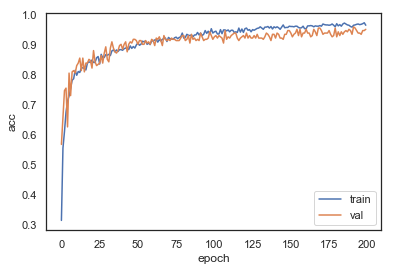

In [78]:
metric = 'acc' # 'loss' | 'acc'
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch')
plt.ylabel(metric)
plt.legend()

In [79]:
# apply the model to test data
p = lsc_inception.predict(ap_test)
p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
pred = np.argmax(p, axis=-1)
acc_inception = round(accuracy_score(pred, y_test) * 100, 2)
print('The accuracy for inception model is ' + str(acc_inception) + '%')

The accuracy for inception model is 94.83%


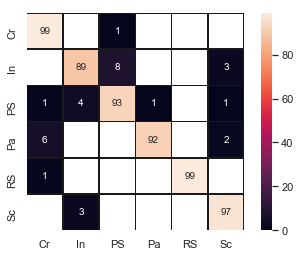

In [80]:
evaluate_confusion_matrix(lsc_inception, ap_test, y_test)

# 4. ResNet50

Residual networks were a breakthrough idea which enabled the development of much deeper networks (hundreds of layers). In residual learning, instead of trying to learn some features, we try to learn some residual (subtraction of feature learned from input of that layer). ResNet does this using shortcut connections. It has proved that training this form of networks is easier than training simple deep cnns and the problem of degrading accuracy is resolved. The structure of ResNet50 is as below. ResNet50 is a 50 layer ResNet.

In [58]:
model = resnet50.ResNet50(weights=None)
print("model structure: ", model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [59]:
def preprocess_images_resnet(images):
    """ expect a 3D array containing grayscale uint8 images """

    # resize images with scipy
    I = np.array([resize(image, (224,224)) for image in images])

    # convert to RGB and apply imagenet preprocessing
    I = gray2rgb(I).astype(np.float32)

    return resnet50.preprocess_input(I)

In [60]:
def resnet_layer(output_name='avg_pool'):
    # Note: currently hippolyta compute nodes cannot access user home directories,
    # and do not have direct internet access.
    # use full paths to NFS filesystem endpoints (not symlinks)
    # keras pretrained model weight files are here:
    #KERAS_ROOT = 'D:\Python\CV Project\defect'
    #weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    #weights_path = os.path.join(KERAS_ROOT, 'models', weights_file)

    # initialize network with random weights, and load from hdf5
    cnn = resnet50.ResNet50(include_top=True, weights='imagenet', classes=1000)
    #cnn.load_weights(filepath=weights_path)

    model = Model(
        inputs=cnn.input,
        outputs=cnn.get_layer(output_name).output
    )

    return model

In [61]:
def cached_forward_pass_resnet(images, phase='train', layername='avg_pool', datadir='../data'):
        
    datafile = os.path.join(datadir, 'neu-resnet-{}-{}.npy'.format(layername, phase))
    try:
        features = np.load(datafile)
    except FileNotFoundError:
        print('forward pass for NEU {}ing images'.format(phase))
        model = inception_layer(layername)
        features = model.predict(preprocess_images_resnet(images), verbose=True)
        np.save(datafile, features)

    return features

In [62]:
datadir='D:\Python\CV Project - defect classification\data'

rnap_train = cached_forward_pass_resnet(train_images, phase='train', layername='avg_pool', datadir=datadir)
rnap_test = cached_forward_pass_resnet(test_images, phase='test', layername='avg_pool', datadir=datadir)

In [85]:
ntrain = train_images.shape[0]

lsc_resnet = linear_softmax_classifier(input_dim=2048)
opt = optimizers.Adam(lr=0.005)
lsc_resnet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(y_train)

# shuffle training data to get shuffled validation data
initial_shuf = np.random.permutation(ntrain)
X = rnap_train[initial_shuf]
y = target[initial_shuf]

hist = lsc_resnet.fit(X, y, validation_split=0.2, epochs=500)

Train on 960 samples, validate on 240 samples
Epoch 1/500
960/960 [==============================] - 3s 3ms/step - loss: 1.9099 - acc: 0.1740 - val_loss: 1.8136 - val_acc: 0.1625
Epoch 2/500
960/960 [==============================] - 0s 183us/step - loss: 1.7960 - acc: 0.2010 - val_loss: 1.7772 - val_acc: 0.2167
Epoch 3/500
960/960 [==============================] - 0s 172us/step - loss: 1.7830 - acc: 0.2125 - val_loss: 1.7971 - val_acc: 0.2500
Epoch 4/500
960/960 [==============================] - 0s 178us/step - loss: 1.7297 - acc: 0.2729 - val_loss: 1.7809 - val_acc: 0.2125
Epoch 5/500
960/960 [==============================] - 0s 172us/step - loss: 1.6931 - acc: 0.2792 - val_loss: 1.8856 - val_acc: 0.1333
Epoch 6/500
960/960 [==============================] - 0s 172us/step - loss: 1.6868 - acc: 0.2740 - val_loss: 1.7030 - val_acc: 0.2542
Epoch 7/500
960/960 [==============================] - 0s 168us/step - loss: 1.6811 - acc: 0.2865 - val_loss: 1.6766 - val_acc: 0.3125
Epoch 8/500

Epoch 61/500
960/960 [==============================] - 0s 170us/step - loss: 1.2123 - acc: 0.5677 - val_loss: 1.2022 - val_acc: 0.5458
Epoch 62/500
960/960 [==============================] - 0s 171us/step - loss: 1.2017 - acc: 0.6021 - val_loss: 1.2901 - val_acc: 0.5292
Epoch 63/500
960/960 [==============================] - 0s 162us/step - loss: 1.1772 - acc: 0.6385 - val_loss: 1.1827 - val_acc: 0.7125
Epoch 64/500
960/960 [==============================] - 0s 175us/step - loss: 1.2114 - acc: 0.5562 - val_loss: 1.2039 - val_acc: 0.5292
Epoch 65/500
960/960 [==============================] - 0s 170us/step - loss: 1.1853 - acc: 0.5854 - val_loss: 1.1688 - val_acc: 0.6833
Epoch 66/500
960/960 [==============================] - 0s 169us/step - loss: 1.2039 - acc: 0.5604 - val_loss: 1.1975 - val_acc: 0.6583
Epoch 67/500
960/960 [==============================] - 0s 170us/step - loss: 1.2261 - acc: 0.5333 - val_loss: 1.2419 - val_acc: 0.5667
Epoch 68/500
960/960 [==========================

960/960 [==============================] - 0s 175us/step - loss: 1.0318 - acc: 0.6604 - val_loss: 1.1872 - val_acc: 0.5542
Epoch 122/500
960/960 [==============================] - 0s 179us/step - loss: 1.0459 - acc: 0.6490 - val_loss: 1.0224 - val_acc: 0.7542
Epoch 123/500
960/960 [==============================] - 0s 193us/step - loss: 1.0339 - acc: 0.6812 - val_loss: 1.0330 - val_acc: 0.6292
Epoch 124/500
960/960 [==============================] - 0s 178us/step - loss: 1.0158 - acc: 0.6792 - val_loss: 1.0582 - val_acc: 0.7542
Epoch 125/500
960/960 [==============================] - 0s 172us/step - loss: 1.0312 - acc: 0.7083 - val_loss: 1.0582 - val_acc: 0.6208
Epoch 126/500
960/960 [==============================] - 0s 178us/step - loss: 1.0305 - acc: 0.6573 - val_loss: 1.0637 - val_acc: 0.6708
Epoch 127/500
960/960 [==============================] - 0s 174us/step - loss: 1.0363 - acc: 0.6500 - val_loss: 1.0536 - val_acc: 0.6000
Epoch 128/500
960/960 [==============================] 

Epoch 181/500
960/960 [==============================] - 0s 169us/step - loss: 0.9045 - acc: 0.7521 - val_loss: 0.9236 - val_acc: 0.7000
Epoch 182/500
960/960 [==============================] - 0s 171us/step - loss: 0.9364 - acc: 0.7146 - val_loss: 0.9449 - val_acc: 0.7000
Epoch 183/500
960/960 [==============================] - 0s 168us/step - loss: 0.9538 - acc: 0.6594 - val_loss: 1.0037 - val_acc: 0.6792
Epoch 184/500
960/960 [==============================] - 0s 172us/step - loss: 0.9199 - acc: 0.7042 - val_loss: 0.9454 - val_acc: 0.6625
Epoch 185/500
960/960 [==============================] - 0s 173us/step - loss: 0.9068 - acc: 0.7385 - val_loss: 0.8997 - val_acc: 0.7667
Epoch 186/500
960/960 [==============================] - 0s 179us/step - loss: 0.9262 - acc: 0.7021 - val_loss: 0.9747 - val_acc: 0.7375
Epoch 187/500
960/960 [==============================] - 0s 182us/step - loss: 0.8809 - acc: 0.7521 - val_loss: 0.9658 - val_acc: 0.7000
Epoch 188/500
960/960 [==================

960/960 [==============================] - 0s 179us/step - loss: 0.8329 - acc: 0.7812 - val_loss: 0.8266 - val_acc: 0.7625
Epoch 241/500
960/960 [==============================] - 0s 173us/step - loss: 0.8399 - acc: 0.7708 - val_loss: 0.8622 - val_acc: 0.7500
Epoch 242/500
960/960 [==============================] - 0s 175us/step - loss: 0.8375 - acc: 0.7677 - val_loss: 0.9097 - val_acc: 0.7250
Epoch 243/500
960/960 [==============================] - 0s 186us/step - loss: 0.8455 - acc: 0.7719 - val_loss: 0.8253 - val_acc: 0.8083
Epoch 244/500
960/960 [==============================] - 0s 174us/step - loss: 0.8255 - acc: 0.7615 - val_loss: 0.8223 - val_acc: 0.7833
Epoch 245/500
960/960 [==============================] - 0s 184us/step - loss: 0.8258 - acc: 0.7729 - val_loss: 0.8669 - val_acc: 0.7000
Epoch 246/500
960/960 [==============================] - 0s 170us/step - loss: 0.8460 - acc: 0.7708 - val_loss: 0.8375 - val_acc: 0.7583
Epoch 247/500
960/960 [==============================] 

Epoch 300/500
960/960 [==============================] - 0s 195us/step - loss: 0.7713 - acc: 0.7865 - val_loss: 0.8149 - val_acc: 0.7792
Epoch 301/500
960/960 [==============================] - 0s 211us/step - loss: 0.7663 - acc: 0.7802 - val_loss: 0.7899 - val_acc: 0.7875
Epoch 302/500
960/960 [==============================] - 0s 210us/step - loss: 0.7529 - acc: 0.8062 - val_loss: 0.7792 - val_acc: 0.7875
Epoch 303/500
960/960 [==============================] - 0s 213us/step - loss: 0.7723 - acc: 0.7802 - val_loss: 0.7634 - val_acc: 0.7958
Epoch 304/500
960/960 [==============================] - 0s 181us/step - loss: 0.7767 - acc: 0.7865 - val_loss: 0.8368 - val_acc: 0.7917
Epoch 305/500
960/960 [==============================] - 0s 172us/step - loss: 0.7718 - acc: 0.7823 - val_loss: 0.7589 - val_acc: 0.7958
Epoch 306/500
960/960 [==============================] - 0s 176us/step - loss: 0.7786 - acc: 0.7719 - val_loss: 0.8101 - val_acc: 0.8125
Epoch 307/500
960/960 [==================

Epoch 360/500
960/960 [==============================] - 0s 164us/step - loss: 0.7363 - acc: 0.8000 - val_loss: 0.7521 - val_acc: 0.7542
Epoch 361/500
960/960 [==============================] - 0s 173us/step - loss: 0.7456 - acc: 0.7740 - val_loss: 0.7655 - val_acc: 0.6917
Epoch 362/500
960/960 [==============================] - 0s 172us/step - loss: 0.7193 - acc: 0.7812 - val_loss: 0.7330 - val_acc: 0.8000
Epoch 363/500
960/960 [==============================] - 0s 178us/step - loss: 0.7580 - acc: 0.7667 - val_loss: 0.8264 - val_acc: 0.6542
Epoch 364/500
960/960 [==============================] - 0s 172us/step - loss: 0.7460 - acc: 0.7677 - val_loss: 0.7212 - val_acc: 0.8042
Epoch 365/500
960/960 [==============================] - 0s 176us/step - loss: 0.7264 - acc: 0.7875 - val_loss: 0.8355 - val_acc: 0.7458
Epoch 366/500
960/960 [==============================] - 0s 174us/step - loss: 0.7242 - acc: 0.7854 - val_loss: 0.7406 - val_acc: 0.8417
Epoch 367/500
960/960 [==================

Epoch 420/500
960/960 [==============================] - 0s 174us/step - loss: 0.6720 - acc: 0.8229 - val_loss: 0.7007 - val_acc: 0.8000
Epoch 421/500
960/960 [==============================] - 0s 174us/step - loss: 0.6974 - acc: 0.8052 - val_loss: 0.6769 - val_acc: 0.8167
Epoch 422/500
960/960 [==============================] - 0s 175us/step - loss: 0.6876 - acc: 0.8135 - val_loss: 0.6846 - val_acc: 0.8000
Epoch 423/500
960/960 [==============================] - 0s 170us/step - loss: 0.6907 - acc: 0.8031 - val_loss: 0.7479 - val_acc: 0.7917
Epoch 424/500
960/960 [==============================] - 0s 172us/step - loss: 0.7038 - acc: 0.7906 - val_loss: 0.7622 - val_acc: 0.8208
Epoch 425/500
960/960 [==============================] - 0s 183us/step - loss: 0.6828 - acc: 0.8115 - val_loss: 0.6809 - val_acc: 0.8333
Epoch 426/500
960/960 [==============================] - 0s 169us/step - loss: 0.6674 - acc: 0.8135 - val_loss: 0.7517 - val_acc: 0.8000
Epoch 427/500
960/960 [==================

960/960 [==============================] - 0s 180us/step - loss: 0.6620 - acc: 0.8219 - val_loss: 0.6817 - val_acc: 0.8250
Epoch 480/500
960/960 [==============================] - 0s 172us/step - loss: 0.6596 - acc: 0.8115 - val_loss: 0.6601 - val_acc: 0.8125
Epoch 481/500
960/960 [==============================] - 0s 172us/step - loss: 0.6550 - acc: 0.8250 - val_loss: 0.6772 - val_acc: 0.8167
Epoch 482/500
960/960 [==============================] - 0s 178us/step - loss: 0.6519 - acc: 0.8177 - val_loss: 0.6766 - val_acc: 0.8250
Epoch 483/500
960/960 [==============================] - 0s 181us/step - loss: 0.6509 - acc: 0.8281 - val_loss: 0.6432 - val_acc: 0.8292
Epoch 484/500
960/960 [==============================] - 0s 191us/step - loss: 0.6653 - acc: 0.8094 - val_loss: 0.6609 - val_acc: 0.8083
Epoch 485/500
960/960 [==============================] - 0s 161us/step - loss: 0.6379 - acc: 0.8250 - val_loss: 0.7121 - val_acc: 0.7500
Epoch 486/500
960/960 [==============================] 

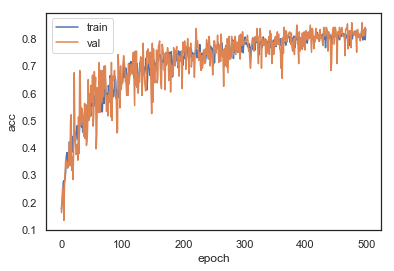

In [86]:
metric = 'acc' # 'loss' | 'acc'
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch')
plt.ylabel(metric)
plt.legend()

In [87]:
# apply the model to test data
p = lsc_resnet.predict(rnap_test)
p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
pred = np.argmax(p, axis=-1)
acc_resnet = round(accuracy_score(pred, y_test) * 100, 2)
print('The accuracy for ResNet50 model is ' + str(acc_resnet) + '%')

The accuracy for ResNet50 model is 79.33%


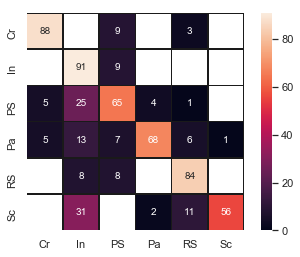

In [88]:
evaluate_confusion_matrix(lsc_rnap, rnap_test, y_test)

# 5. Model performance comparison

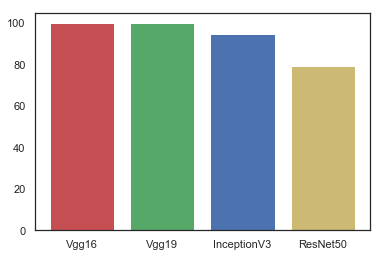

In [103]:
#Compare the accuracy_score for the four models

hist = (acc_vgg16,acc_vgg19,acc_inception,acc_resnet)
hist_bin = ['Vgg16', 'Vgg19', 'InceptionV3', 'ResNet50']

plt.bar(np.arange(4),hist, tick_label=hist_bin,color=('r', 'g', 'b', 'y'))
plt.show()